# A [RD](https://en.wikipedia.org/wiki/Rate%E2%80%93distortion_theory)-comparison of "Stereo" Transforms

Note: some results provided by this notebook are only generated if the audio signal is stereo. This notebook should be run locally (do not run it in Google Colab, for example).

In [1]:
import sounddevice as sd
import pywt # pip install pywavelets
import math
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from scipy import signal
import zlib
import pylab

In [2]:
def plot(y, xlabel='', ylabel='', title=''):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.grid()
    ax.xaxis.set_label_text(xlabel)
    ax.yaxis.set_label_text(ylabel)
    x = np.linspace(0, len(y)-1, len(y))
    ax.plot(x, y, '.', markersize=1)
    plt.show(block=False)

## Produce some sound ... for example, speak for 5 seconds
The audio signal will be used to compare the RD performance of the transforms.

In [3]:
fs = 44100      # Sampling frequency
duration = 5.0  # seconds
x = sd.rec(int(duration * fs), samplerate=fs, channels=2, dtype=np.int16)
print("Say something!")
while sd.wait():
    pass
print("done")

Say something!
done


## This is your audio

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


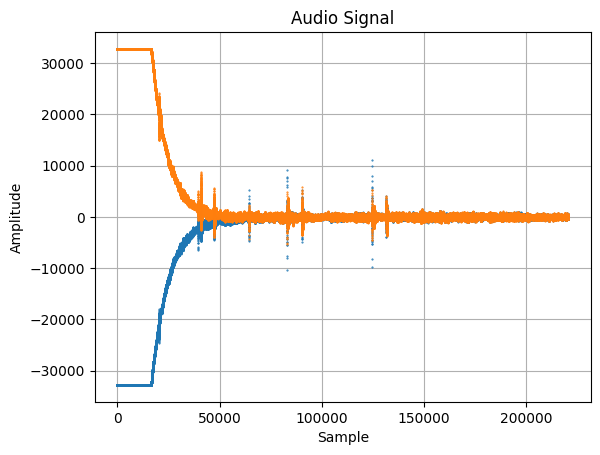

In [4]:
sd.play(x)
plot(x, "Sample", "Amplitude", "Audio Signal")

## Let's remove some samples from the begining

In [5]:
x = x[50000:]

## This is your definitive audio sequence

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


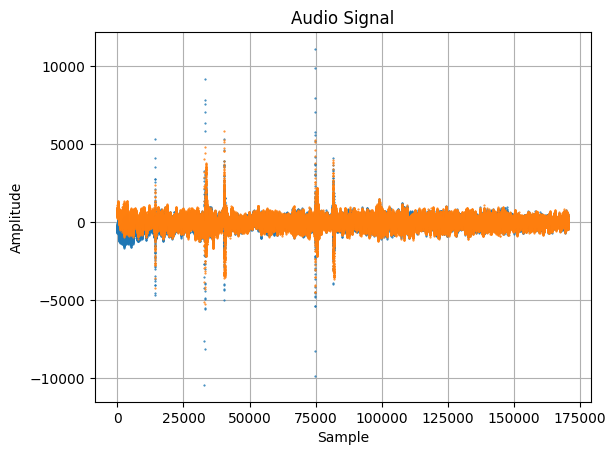

In [6]:
sd.play(x)
plot(x, "Sample", "Amplitude", "Audio Signal")

## Let's zoom the signal

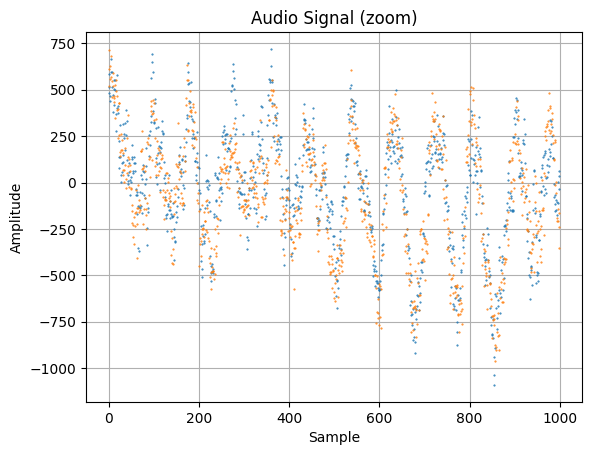

In [7]:
chunk = x[101000:102000]
plot(chunk, "Sample", "Amplitude", "Audio Signal (zoom)")

## Listen to the channel 0

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


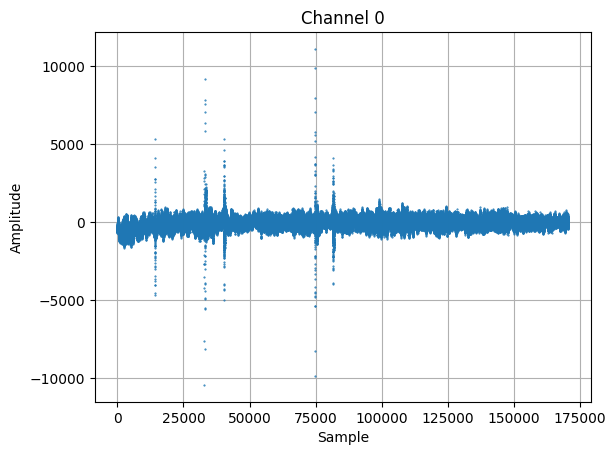

In [8]:
channel_0 = x[:, 0]
sd.play(channel_0)
plot(channel_0, "Sample", "Amplitude", "Channel 0")

## Listen to the channel 1

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


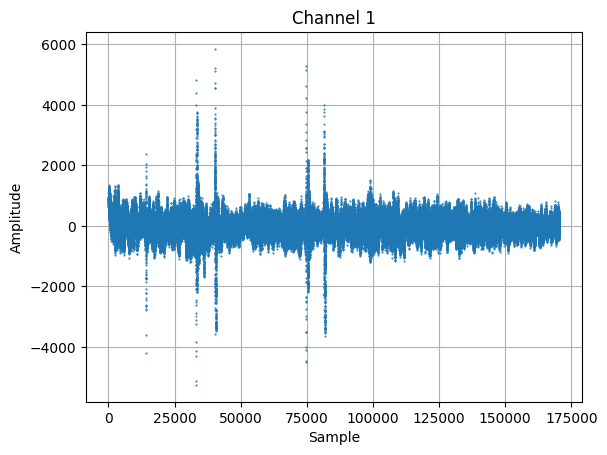

In [9]:
channel_1 = x[:, 1]
sd.play(channel_1)
plot(channel_1, "Sample", "Amplitude", "Channel 1")

## Differences between the channels

In [10]:
differences = channel_0 - channel_1

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


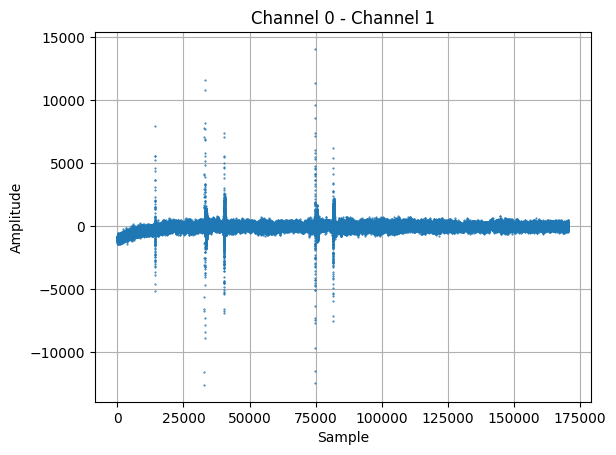

In [11]:
sd.play(differences)
plot(differences, "Sample", "Amplitude", "Channel 0 - Channel 1")

## Average

In [12]:
average = ((channel_1 + channel_0)/2.0).astype(np.int16)

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


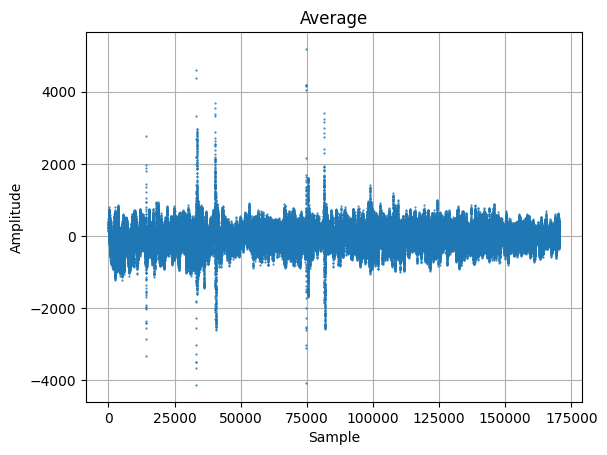

In [13]:
sd.play(average)
plot(average, "Sample", "Amplitude", "Average")

## Is the "transform" reversible?

In [14]:
channel_1 = channel_0 - differences

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


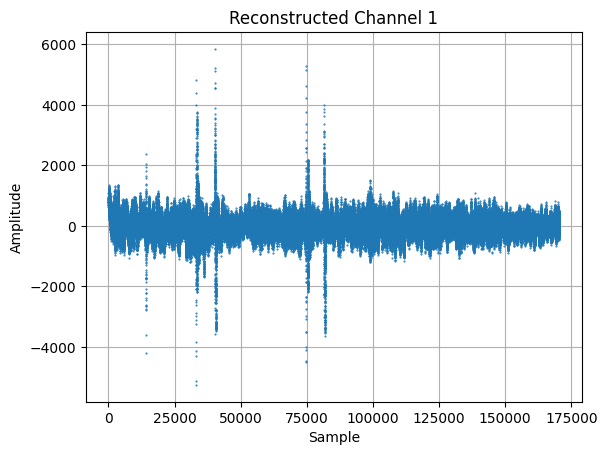

In [15]:
recons_channel_1 = x[:, 1]
sd.play(recons_channel_1)
plot(recons_channel_1, "Sample", "Amplitude", "Reconstructed Channel 1")

In [16]:
channel_1.all() == recons_channel_1.all()

True

Yes!

## Some RD stuff

In [17]:
def average_energy(x):
    #return np.sum(x[:, 0].astype(np.double)*x[:, 0].astype(np.double))/len(x[:, 0]) + \
    #       np.sum(x[:, 1].astype(np.double)*x[:, 1].astype(np.double))/len(x[:, 1])
    return np.sum(x.astype(np.double)*x.astype(np.double))/len(x)
    
def RMSE(x, y):
    error_signal = x - y
    return math.sqrt(average_energy(error_signal))

# Based on https://stackoverflow.com/questions/15450192/fastest-way-to-compute-entropy-in-python
def entropy_in_bits_per_symbol(sequence_of_symbols):
    value, counts = np.unique(sequence_of_symbols, return_counts = True)
    probs = counts / len(sequence_of_symbols)
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    entropy = 0.
    for i in probs:
        entropy -= i * math.log(i, 2)

    return entropy

def deadzone_quantizer(x, quantization_step):
    k = (x / quantization_step).astype(np.int32)
    return k

def deadzone_dequantizer(k, quantization_step):
    y = quantization_step * k
    return y

def deadzone_qdeq(x, quantization_step):
    k = deadzone_quantizer(x, quantization_step)
    y = deadzone_dequantizer(k, quantization_step)
    return k, y

def RD_curve(data, analyze, synthesize):
    RD_points = []
    for q_step in range(16, 1024, 32):
        analyzed_data = analyze(data)
        k, y = deadzone_qdeq(analyzed_data, q_step)
        rate = entropy_in_bits_per_symbol(k[:, 0]) + entropy_in_bits_per_symbol(k[:, 1])
        reconstructed_data = synthesize(y)
        distortion = RMSE(data, reconstructed_data)
        RD_points.append((rate, distortion))
    return RD_points

## [Karhunen-Loéve Transform (KLT)](https://en.wikipedia.org/wiki/Karhunen%E2%80%93Lo%C3%A8ve_theorem), [Hadamard](https://en.wikipedia.org/wiki/Hadamard_transform) and [Haar](https://en.wikipedia.org/wiki/Haar_wavelet#Haar_matrix)

The rows (i.e., the [basis](https://en.wikipedia.org/wiki/Basis_(linear_algebra)) vectors) of the of the [discrete](https://en.wikipedia.org/wiki/Discrete_transform) (all transforms discussed in this document are discrete) KLT consist of the [eigenvectors](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors#:~:text=In%20linear%20algebra%2C%20an%20eigenvector,which%20the%20eigenvector%20is%20scaled.) of the [autorrelation matrix](https://en.wikipedia.org/wiki/Autocorrelation#Auto-correlation_of_random_vectors) (also known as the [covariance](https://en.wikipedia.org/wiki/Covariance) matrix) of the transformed signal. In block-based [transform coding](https://web.stanford.edu/class/ee368b/Handouts/11-TransformCoding.pdf) (such as it happens in InterCom in which the audio signal is splitted into frames and chunks) it can be assumed that, on average, the amount of information provided by a subband (the set of coefficients that correspond to a given frequency) is proportional to the variance in this subband, computed over the coefficients of the subband for different blocks.

The KLT minimizes the [geometric mean](https://en.wikipedia.org/wiki/Geometric_mean) of the variance of the transform coefficients. Hence, the KLT provides optimum energy concentration and therefore, the largest [Transform Coding Gain (TCG)](http://ws2.binghamton.edu/fowler/fowler%20personal%20page/EE523_files/Ch_13_3%20Transform%20Coding%20-%20Coding%20Gain%20&%20Classic%20Transforms%20(PPT).pdf) of any linear transform coding method. Unfortunately, the autocorrelation matrix depends on the input signal and therefore, the [change of basis](https://en.wikipedia.org/wiki/Change_of_basis) (the transform) provided by the KLT is signal dependent (each signal needs to be transformed by a different transform matrix), except in the case of 2-samples transform coding.

## TGC
The TCG is defined as the ratio of the arithmetic mean of the variances of the coefficients to their geometric means:

\begin{equation}
G_{TC} = \frac{\frac{1}{N}\sum_{i=1}^N{\sigma_i^2}}{(\prod_{i=1}^N\sigma_i^2)^{\frac{1}{N}}}
\end{equation}

In the context of signal compression, variance, energy, entropy and information are synonymous.

In [18]:
def TCG(variances):
    N = len(variances)
    arithmetic_mean = np.sum(variances)/N
    geometric_mean = np.prod(variances)**(1/N)
    if geometric_mean == 0:
        geometric_mean = 1
    transform_coding_gain = arithmetic_mean/geometric_mean
    return transform_coding_gain

In [19]:
# KLT analysis transform:
#
#  [w[0]] = 1/sqrt(2) [1  1] [x[0]]
#  [w[1]]             [1 -1] [x[1]]

def KLT_analyze(x):
    w = np.empty_like(x, dtype=np.int32)
    w[:, 0] = np.rint((x[:, 0].astype(np.int32) + x[:, 1]) / math.sqrt(2)) # L
    w[:, 1] = np.rint((x[:, 0].astype(np.int32) - x[:, 1]) / math.sqrt(2)) # H
    return w

# Synthesis transform:
#
#  [x[0]] = 1/sqrt(2) [1  1] [w[0]]
#  [x[1]]             [1 -1] [w[1]]

def KLT_synthesize(w):
    x = np.empty_like(w, dtype=np.int16)
    #x[:, 0] = np.rint((w[:, 0] + w[:, 1]) / math.sqrt(2)) # L(ow frequency subband)
    #x[:, 1] = np.rint((w[:, 0] - w[:, 1]) / math.sqrt(2)) # H(igh frequency subband)
    x[:, :] = KLT_analyze(w)
    return x

## Let's see the KLT subbands

In [20]:
w = KLT_analyze(x)

## First subband (low frequencies)

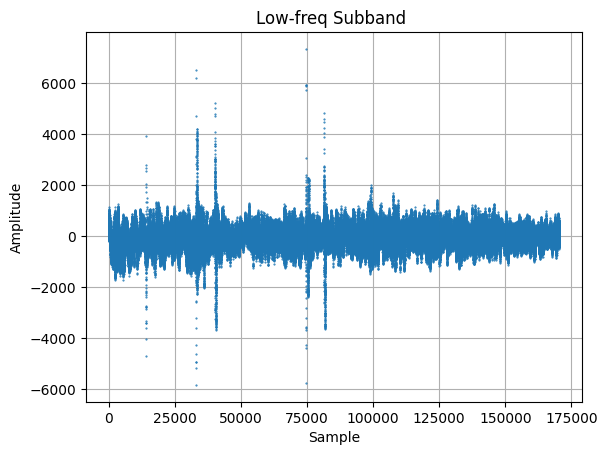

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


In [21]:
plot(w[:, 0], "Sample", "Amplitude", "Low-freq Subband ")
sd.play(w[:, 0].astype(np.int16))

## Second subband (high frequencies)

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


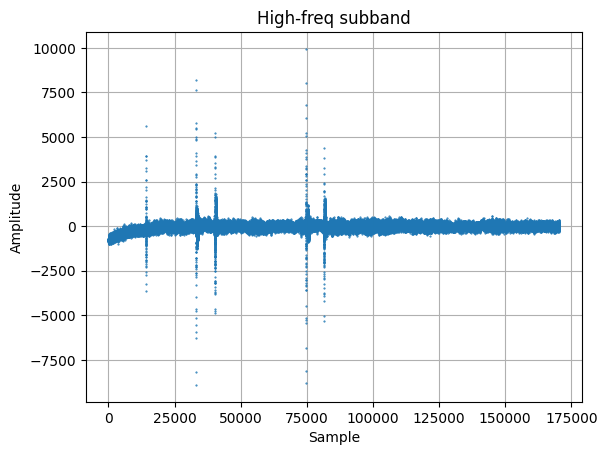

In [22]:
plot(w[:, 1], "Sample", "Amplitude", "High-freq subband")
sd.play(w[:, 1].astype(np.int16))

If you can listen to the low frequencies, this a consequence of the bad slope of the cut-off frequency in the high-frequency filter.

## Frequency vs time in the original signal

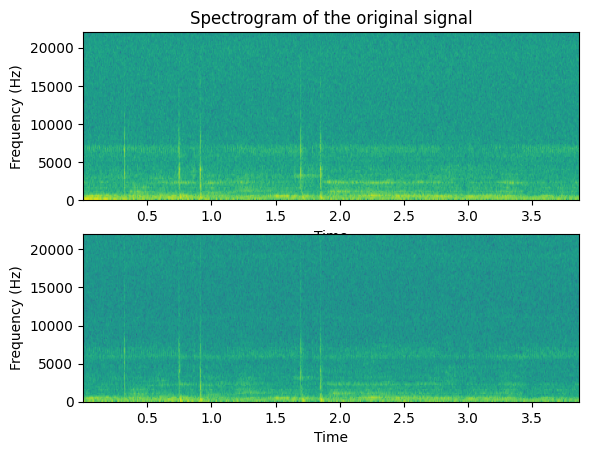

In [23]:
plt.subplot(211)
plt.title('Spectrogram of the original signal')
plt.specgram(x[:, 0], Fs=44100)
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.subplot(212)
plt.specgram(x[:, 1], Fs=44100)
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.show()

## Frequency vs time in the transformed signal

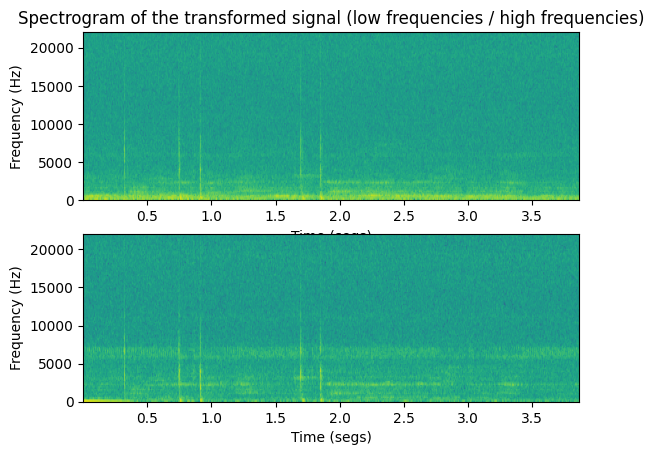

In [24]:
plt.subplot(211)
plt.title('Spectrogram of the transformed signal (low frequencies / high frequencies)')
plt.specgram(w[:, 0], Fs=44100)
plt.xlabel('Time (segs)')
plt.ylabel('Frequency (Hz)')
plt.subplot(212)
plt.specgram(w[:, 1], Fs=44100)
plt.xlabel('Time (segs)')
plt.ylabel('Frequency (Hz)')
plt.show()

You should see more energy of higher frequency in the high-frequency subband, and viceversa.

## [Filter's response in the frequency domain](https://en.wikipedia.org/wiki/Filter_(signal_processing)#The_transfer_function)

/tmp/ipykernel_40168/533607858.py:13: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w2, 20 * np.log10(abs(h2)), 'b')


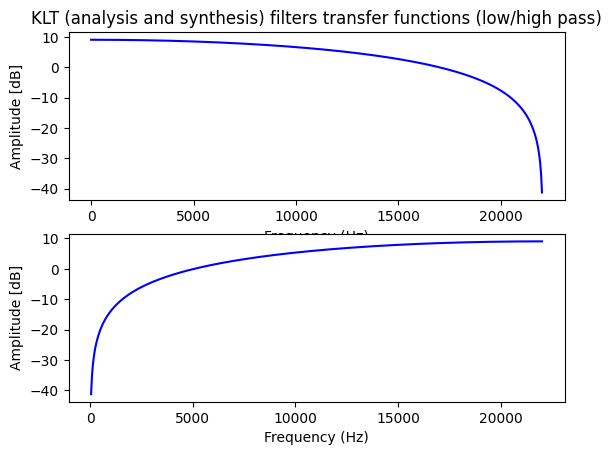

In [25]:
sqrt2 = math.sqrt(2)
K1 = np.array([sqrt2, sqrt2])
w1, h1 = signal.freqz(K1, fs=44100)
K2 = np.array([sqrt2, -sqrt2])
w2, h2 = signal.freqz(K2, fs=44100)

plt.subplot(211)
plt.title('KLT (analysis and synthesis) filters transfer functions (low/high pass)')
plt.plot(w1, 20 * np.log10(abs(h1)), 'b')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude [dB]')
plt.subplot(212)
plt.plot(w2, 20 * np.log10(abs(h2)), 'b')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude [dB]')
plt.show()

Notice that the [transition band](https://en.wikipedia.org/wiki/Transition_band) of these filters is very vage, in the sense that the transition between the pass band and the stop band is very wide (the transition band is very large). This implies that these filters are quite uneffective. However, this is the maximum performance that we can get using only two coeffients (or taps)/filter (remember that the KLT is an optimal transform, but obviosly, the spectral separation depends on the number of filters and their length).

Notice also that these filters are [Quadrature Mirror Filters (QMF)](https://en.wikipedia.org/wiki/Quadrature_mirror_filter). Thanks to this, even when there is a high degree of aliasing between the filters, the perfect reconstruction is possible.

## [Mid/Side Transform (MST)](https://en.wikipedia.org/wiki/Joint_encoding#M/S_stereo_coding)

MST represents the left and right channels as a *mid* subband (also sometimes called again channel) and a *side* subband. The mid subband is the sum of the left and right channels ($M=L+R$). The side subband is the difference of the left and right channels ($S=L-R$). See also Section 2.2.1. *Sum-Difference coding* at this [PhD thesis](https://research.tue.nl/en/studentTheses/stereo-coding-by-two-channel-linear-prediction-and-rotation).

In [26]:
# Analysis transform:
#
#  [w[0]] = [1  1] [x[0]]
#  [w[1]]   [1 -1] [x[1]]

def MST_analyze(x):
    w = np.empty_like(x, dtype=np.int32)
    w[:, 0] = x[:, 0].astype(np.int32) + x[:, 1] # L(ow frequency subband)
    w[:, 1] = x[:, 0].astype(np.int32) - x[:, 1] # H(igh frequency subband)
    return w

# Inverse transform:
#
#  [x[0]] = 1/2 [1  1] [w[0]]
#  [x[1]]       [1 -1] [w[1]]

def MST_synthesize(w):
    x = np.empty_like(w, dtype=np.int16)
    x[:, 0] = (w[:, 0] + w[:, 1])/2 # L(ow frequency subband)
    x[:, 1] = (w[:, 0] - w[:, 1])/2 # H(igh frequency subband)
    return x

# This solution is slower than the previous one because: (1) an array of int32 is allocated,
# and (2) the memory locality is smaller (the division by 2 is not performed just when
# the samples are accesed).
def _MST_synthesize(w):
    x = np.empty_like(w, dtype=np.int16)
    x[:, :] = MST_analyze(w)
    x = x / 2
    return x

## MST subbands

In [27]:
w = MST_analyze(x)

## Mid subband (low frequencies)

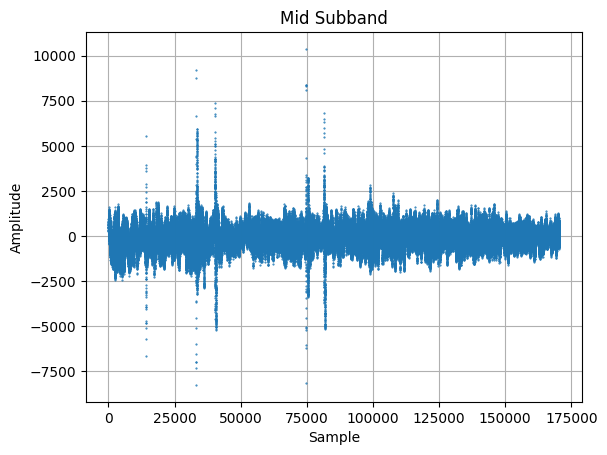

In [28]:
plot(w[:, 0], "Sample", "Amplitude", "Mid Subband")
sd.play(w[:, 0].astype(np.int16))

## Side subband (high frequencies)

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


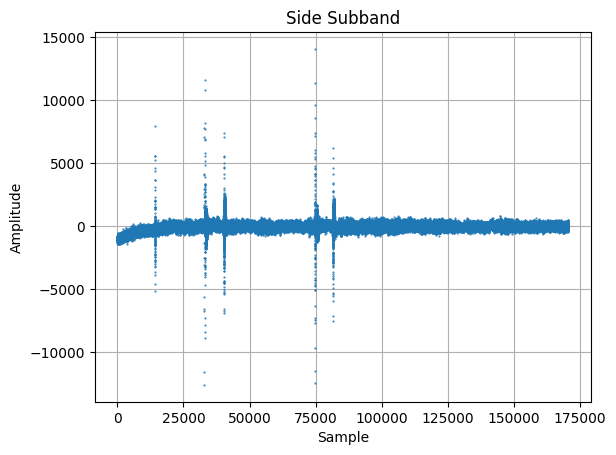

In [29]:
plot(w[:, 1], "Sample", "Amplitude", "Side Subband")
sd.play(w[:, 1].astype(np.int16))

## Frequency vs time in the original signal

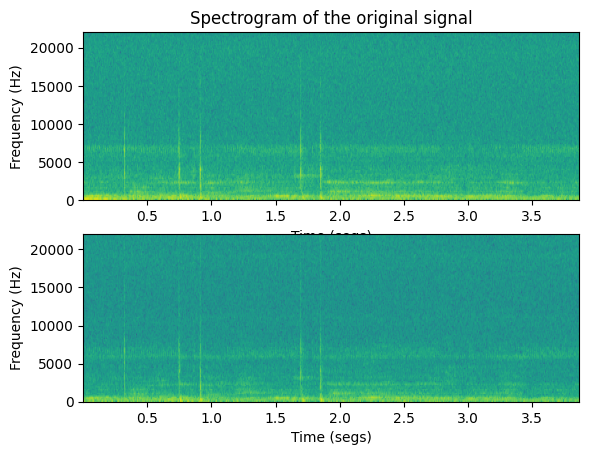

In [30]:
plt.subplot(211)
plt.title('Spectrogram of the original signal')
plt.specgram(x[:, 0], Fs=44100)
plt.xlabel('Time (segs)')
plt.ylabel('Frequency (Hz)')
plt.subplot(212)
plt.specgram(x[:, 1],Fs=44100)
plt.xlabel('Time (segs)')
plt.ylabel('Frequency (Hz)')
plt.show()

## Frequency vs time in the transformed signal

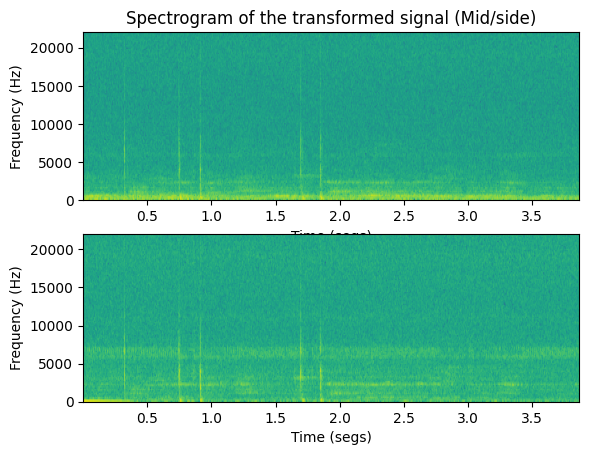

In [31]:
plt.subplot(211)
plt.title('Spectrogram of the transformed signal (Mid/side)')
plt.specgram(w[:, 0], Fs=44100)
plt.xlabel('Time (segs)')
plt.ylabel('Frequency (Hz)')
plt.subplot(212)
plt.specgram(w[:, 1], Fs=44100)
plt.xlabel('Time (segs)')
plt.ylabel('Frequency (Hz)')
plt.show()

## Filter's response in the frequency domain

/tmp/ipykernel_40168/2610546299.py:12: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w2, 20 * np.log10(abs(h2)), 'b')


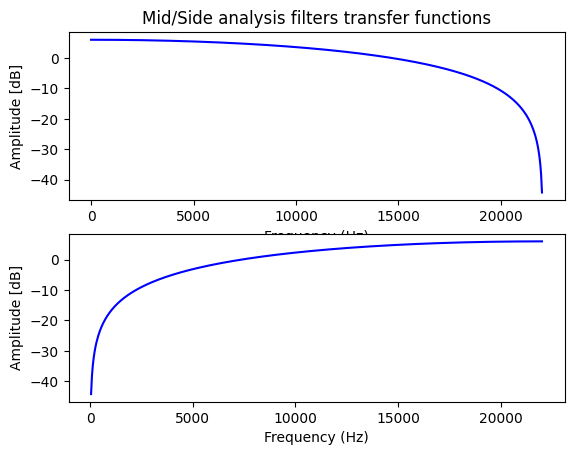

In [32]:
K1 = np.array([1.0, 1.0])
w1, h1 = signal.freqz(K1, fs=44100)
K2 = np.array([1.0, -1.0])
w2, h2 = signal.freqz(K2, fs=44100)

plt.subplot(211)
plt.title('Mid/Side analysis filters transfer functions')
plt.plot(w1, 20 * np.log10(abs(h1)), 'b')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude [dB]')
plt.subplot(212)
plt.plot(w2, 20 * np.log10(abs(h2)), 'b')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude [dB]')
plt.show()

The frequency response of the MST filters is identical to the freq. response of the 2x2 KLT.

## MST vs KLT from a RD perspective

In [33]:
MST_RD_points = RD_curve(x, MST_analyze, MST_synthesize)

In [34]:
KLT_RD_points = RD_curve(x, KLT_analyze, KLT_synthesize)

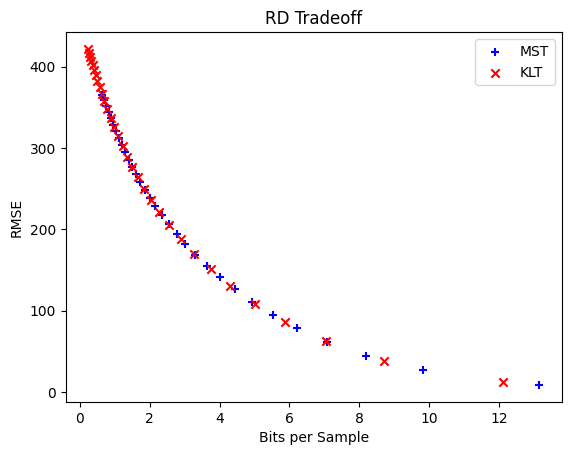

In [35]:
plt.title("RD Tradeoff")
plt.xlabel("Bits per Sample")
plt.ylabel("RMSE")
#plt.xscale("log")
#plt.yscale("log")
plt.scatter(*zip(*MST_RD_points), c='b', marker="+", label='MST')
plt.scatter(*zip(*KLT_RD_points), c='r', marker="x", label='KLT')
plt.legend(loc='upper right')
plt.show()

## Timmings

In [36]:
%timeit MST_synthesize(MST_analyze(x))

1.31 ms ± 109 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [37]:
%timeit KLT_synthesize(KLT_analyze(x))

2.23 ms ± 300 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## RD conclusions

MST and KLT are equivalent from a R/D perspective. However, MST is faster.

## Let's see the TGC

In [38]:
LH = MST_analyze(x)
L = LH[:, 0]
H = LH[:, 1]
variances = [None]*2
variances[0] = np.var(L)
variances[1] = np.var(H)
print(TCG(variances))

1.2244273320571613


In [39]:
LH = KLT_analyze(x)
L = LH[:, 0]
H = LH[:, 1]
variances = [None]*2
variances[0] = np.var(L)
variances[1] = np.var(H)
print(TCG(variances))

1.2244245501850657


The TCG of the KLT used to be sliiiightly better than the TCG of the MSC.

## S Transform (ST)
Another transform, only for the sake of curiosity.

In [40]:
# https://www.researchgate.net/profile/Amir_Said2/publication/2598141_Reversible_Image_Compression_Via_Multiresolution_Representation_and_Predictive_Coding/links/56952cf008ae820ff074a536/Reversible-Image-Compression-Via-Multiresolution-Representation-and-Predictive-Coding.pdf
#
# Forward transform:
#
#  w[0] = ceil((x[0] + x[1])/2)
#  w[1] = x[0] - x[1] 
#
# Inverse transform:
#
#  x[0] = w[0] + ceil((w[1]+1)/2)
#  x[1] = x[0] - w[1]

def ST_analyze(x):
    w = np.empty_like(x, dtype=np.int32)
    w[:, 0] = np.ceil((x[:, 0].astype(np.int32) + x[:, 1])/2)
    w[:, 1] = x[:, 0].astype(np.int32) - x[:, 1]
    return w

def ST_synthesize(w):
    x = np.empty_like(w, dtype=np.int16)
    x[:, 0] = w[:, 0] + np.ceil((w[:, 1] + 1)/2)
    x[:, 1] = x[:, 0] - w[:, 1]
    return x

## ST vs MST

In [41]:
ST_RD_points = RD_curve(x, ST_analyze, ST_synthesize)

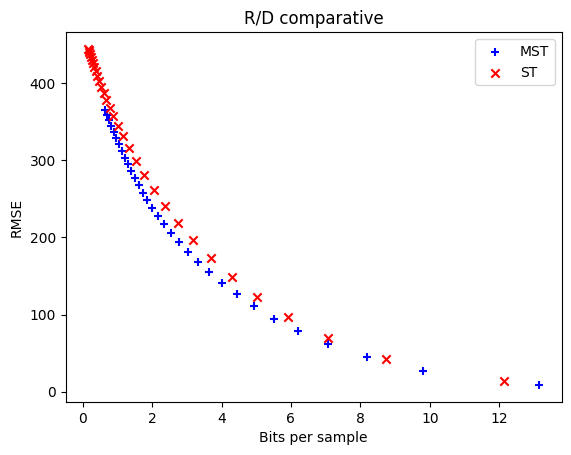

In [42]:
plt.title("R/D comparative")
plt.xlabel("Bits per sample")
plt.ylabel("RMSE")
#plt.xscale("log")
#plt.yscale("log")
plt.scatter(*zip(*MST_RD_points), c='b', marker="+", label='MST')
plt.scatter(*zip(*ST_RD_points), c='r', marker="x", label='ST')
plt.legend(loc='upper right')
plt.show()

MST performs slighly better than ST. This difference probably responds to numeric truncation issues during the transform computation.

## Let's see the RD curve using DEFLATE ...
... instead of the entropy.

In [43]:
def chunk_stereo_DEFLATE_RD_curve(chunk, analyze, synthesize):
    '''RD curve of the chunk.'''
    RD_points = []
    for q_step in range(16, 1024, 32):
        analyzed_chunk = analyze(chunk)
        k, y = deadzone_qdeq(analyzed_chunk, q_step)
        subband_0 = k[:, 0].copy()
        subband_1 = k[:, 1].copy()
        rate = len(zlib.compress(subband_0)) + len(zlib.compress(subband_1))
        #rate = entropy_in_bits_per_symbol(k[:, 0]) + entropy_in_bits_per_symbol(k[:, 1])
        reconstructed_chunk = synthesize(y)
        distortion = RMSE(chunk, reconstructed_chunk)
        RD_points.append((rate, distortion))
    return RD_points

In [44]:
MST_RD_points = chunk_stereo_DEFLATE_RD_curve(x, MST_analyze, MST_synthesize)

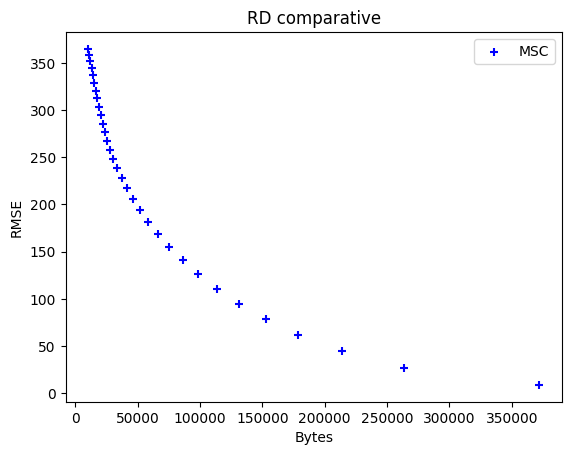

In [45]:
plt.title("RD comparative")
plt.xlabel("Bytes")
plt.ylabel("RMSE")
#plt.xscale("log")
#plt.yscale("log")
plt.scatter(*zip(*MST_RD_points), c='b', marker="+", label='MSC')
#plt.scatter(*zip(*KLT_RD_points), c='r', marker="x", label='KLT')
plt.legend(loc='upper right')
plt.show()

The RD curve using DEFLATE is similar to the one generated using the entropy.

## Impact of  each subband in the distortion of the reconstructed chunk
Reconstructing the signal using only one subband (we compare the reconstructed signal and the original one).

In [46]:
def subband_stereo_DEFLATE_RD_curve(chunk, analyze, synthesize):
    '''RD curves per subband.'''
    mid_RD_points = []
    side_RD_points = []
    for q_step in range(16, 1024, 32):
    #for q_step in range(1):
        #q_step = 16
        analyzed_chunk = analyze(chunk)
        k, y = deadzone_qdeq(analyzed_chunk, q_step)

        # We create side_RD_points by "deleting" subband 0, where mid lives.
        tmp = y.copy()
        tmp[:, 0] = 0
        #print(tmp)
        reconstructed_chunk = synthesize(tmp)
        distortion = RMSE(chunk, reconstructed_chunk)
        rate = len(zlib.compress(k[:, 1].copy()))
        side_RD_points.append((rate, distortion))
        
        # Now create mid_RD_points by "deleting" subband 1, where side is.
        tmp = y.copy()
        tmp[:, 1] = 0
        #print(chunk)
        reconstructed_chunk = synthesize(tmp)
        distortion = RMSE(chunk, reconstructed_chunk)
        rate = len(zlib.compress(k[:, 0].copy()))
        mid_RD_points.append((rate, distortion))
        
    return [mid_RD_points, side_RD_points]

In [47]:
MST_RD_points = subband_stereo_DEFLATE_RD_curve(x, MST_analyze, MST_synthesize)

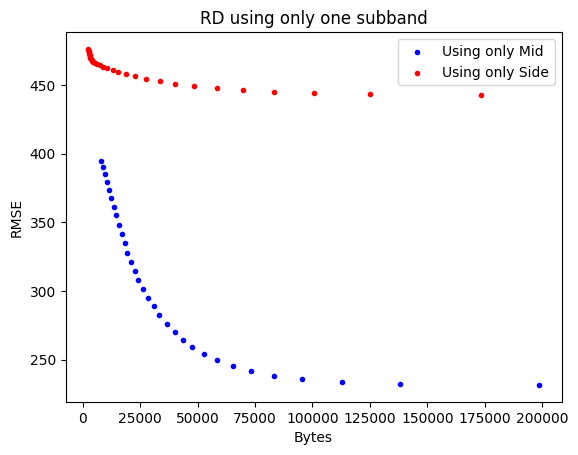

RMSE (using only zeros) = 499.629315425791


In [48]:
plt.title("RD using only one subband")
plt.xlabel("Bytes")
plt.ylabel("RMSE")
#plt.xscale("log")
#plt.yscale("log")
plt.scatter(*zip(*MST_RD_points[0]), c='b', marker=".", label='Using only Mid')
plt.scatter(*zip(*MST_RD_points[1]), c='r', marker=".", label='Using only Side')
#plt.scatter(*zip(*KLT_RD_points), c='r', marker="x", label='KLT')
plt.legend(loc='upper right')
plt.show()
print("RMSE (using only zeros) =", RMSE(x, np.zeros(x.shape)))

### Another view of the same RD curves

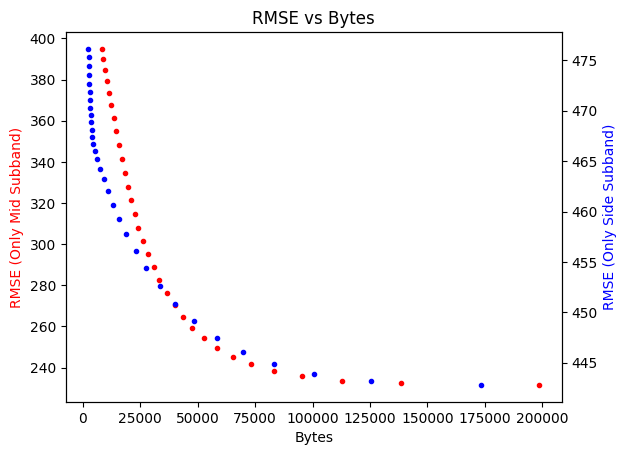

In [49]:
fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.scatter(*zip(*MST_RD_points[0]), c='r', marker=".", label='')
#ax1.legend(loc='upper right')
#ax1.set_title('$\Delta_0=\Delta_1$')
ax1.set_ylabel("RMSE (Only Mid Subband)", color='r')
ax1.set_xlabel("Bytes")
ax1.set_title("RMSE vs Bytes")

ax2 = ax1.twinx()
ax2.scatter(*zip(*MST_RD_points[1]), c='b', marker=".", label='')
#ax2.legend(loc='center right')
ax2.set_ylabel("RMSE (Only Side Subband)", color='b')

plt.show()

As it can be seen, the RD curve of the Mid subband has a larger impact on the quality of the reconstructed audio signal than than the Side channel (the dynamic range of the distortion is higher in the Mid subband). These results suggest that we should transmit more data of the Mid subband that of the Side subband. But what abount the quantization step used for each subband?

## So ... how we must quantize the subbads?

Ideally, in order to maximize the quality of the reconstructed signal, the quantization step for each subband should operate with identical RD slopes.

In [ ]:
slopes = [None]*2
for subband in range(2):
    slopes[subband] = []
    prev = [MST_RD_points[subband][::-1][0][0]+1, 0]
    for i in MST_RD_points[subband][::-1]:
        try:
            slope = (i[1] - prev[1])/(i[0] - prev[0])
        except ZeroDivisionError:
            slope = 0.0
        #print(subband, slope)
        slopes[subband].append(slope)
        prev = i
pylab.plot(np.linspace(0, len(slopes[0])-2, len(slopes[0])-1), slopes[0][1:], label="Mid")
pylab.plot(np.linspace(0, len(slopes[1])-2, len(slopes[1])-1), slopes[1][1:], label="Side")
pylab.legend(loc='lower right')
pylab.title("RD slopes")
pylab.xlabel("Index of the RD point")
pylab.ylabel("Slope")
pylab.show()

This result suggests that we must sent first all data of Mid and then, all data of Side.

## But, what $\Delta$'s combination satisfies this condition? 

The subband gains in the MST ($\sqrt{2}$) suggest that we could use the same quantization step for both subbands, because both subbands have the same gain ($\Delta_0=\Delta_1$). Notice that the dynamic range of $w_0$ is much larger than $w_1$ and therefore, using this heuristic we will send the Side subband only after the most part of the energy of the Mid subband has been send. Remember that we are using a deadzone uniform (scalar) quantizer and therefore, "small" (in amplitude) signals tends to be completelly attenuated except for small $\Delta$'s.

In order to check the performance of this quantization heuristic, we are going to compare two RD curves (in several different configurations). In the first one, $\Delta_0=\Delta_1$, for a set of quantization steps, and in the second curve, we are going to use only one quantization step for one of the subbands (for the other, the quantization step size has been fixed). If the heuristic were good, both curves should "touch" in one point, where also $\Delta_0=\Delta_1$.

# def stereo_DEFLATE_RD_curve_same_deltas(chunk, analyze, synthesize):
    '''Both subbands are quantized using the same quantization step.'''
    RD_points = []
    for q_step in range(16, 2048, 32):
        analyzed_chunk = analyze(chunk)
        k, y = deadzone_qdeq(analyzed_chunk, q_step)
        k_0 = k[:, 0].copy()
        k_1 = k[:, 1].copy()
        rate = len(zlib.compress(k_0)) + len(zlib.compress(k_1))
        #rate = entropy_in_bits_per_symbol(k[:, 0]) + entropy_in_bits_per_symbol(k[:, 1])
        #print(y)
        reconstructed_chunk = synthesize(y)
        distortion = RMSE(chunk, reconstructed_chunk)
        RD_points.append((rate, distortion))
        #RD_points.append((q_step, distortion))
    return RD_points

def stereo_DEFLATE_RD_curve_fixing_delta0(chunk, analyze, synthesize, delta):
    '''Fixes delta_0 and varies delta_1.'''
    RD_points = []
    RQ_points = []
    for q_step in range(16, 2048, 32):
        analyzed_chunk = analyze(chunk)
        subband_0 = analyzed_chunk[:, 0].copy()
        subband_1 = analyzed_chunk[:, 1].copy()
        k_0, y_0 = deadzone_qdeq(subband_0, delta)
        k_1, y_1 = deadzone_qdeq(subband_1, q_step)
        rate = len(zlib.compress(k_0)) + len(zlib.compress(k_1))
        y = np.empty_like(x, dtype=np.int32)
        y[:, 0] = y_0
        y[:, 1] = y_1
        reconstructed_chunk = synthesize(y)
        distortion = RMSE(chunk, reconstructed_chunk)
        RD_points.append((rate, distortion))
        RQ_points.append((rate, q_step))
    return RD_points, RQ_points

def stereo_DEFLATE_RD_curve_fixing_delta1(chunk, analyze, synthesize, delta):
    '''Fixes delta_1 and varies delta_0.'''
    RD_points = []
    QD_points = []
    for q_step in range(16, 2048, 32):
        analyzed_chunk = analyze(chunk)
        subband_0 = analyzed_chunk[:, 0].copy()
        subband_1 = analyzed_chunk[:, 1].copy()
        k_0, y_0 = deadzone_qdeq(subband_0, q_step)
        k_1, y_1 = deadzone_qdeq(subband_1, delta)
        rate = len(zlib.compress(k_0)) + len(zlib.compress(k_1))
        y = np.empty_like(x, dtype=np.int32)
        y[:, 0] = y_0
        y[:, 1] = y_1
        reconstructed_chunk = synthesize(y)
        distortion = RMSE(chunk, reconstructed_chunk)
        RD_points.append((rate, distortion))
        QD_points.append((rate, q_step))
    return RD_points, QD_points

def stereo_DEFLATE_RD_point(chunk, analyze, synthesize, delta):
    '''Compute the RD point for delta_0=delta_1.'''
    RD_points = []
    analyzed_chunk = analyze(chunk)
    subband_0 = analyzed_chunk[:, 0].copy()
    subband_1 = analyzed_chunk[:, 1].copy()
    k_0, y_0 = deadzone_qdeq(subband_0, delta)
    k_1, y_1 = deadzone_qdeq(subband_1, delta)
    rate = len(zlib.compress(k_0)) + len(zlib.compress(k_1))
    y = np.empty_like(x, dtype=np.int32)
    y[:, 0] = y_0
    y[:, 1] = y_1
    reconstructed_chunk = synthesize(y)
    distortion = RMSE(chunk, reconstructed_chunk)
    RD_points.append((rate, distortion))
    return RD_points

In [ ]:
MST_RD_points_same_deltas = stereo_DEFLATE_RD_curve_same_deltas(x, MST_analyze, MST_synthesize)

## $\Delta=256$

In [ ]:
delta = 256
MST_RD_points_fixing_delta0, MST_RQ_points_fixing_delta0 = stereo_DEFLATE_RD_curve_fixing_delta0(x, MST_analyze, MST_synthesize, delta)
MST_RD_points_fixing_delta1, MST_RQ_points_fixing_delta1 = stereo_DEFLATE_RD_curve_fixing_delta1(x, MST_analyze, MST_synthesize, delta)

In [ ]:
MST_RD_point = stereo_DEFLATE_RD_point(x, MST_analyze, MST_synthesize, delta)

In [ ]:
MST_RD_points_same_deltas

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(*zip(*MST_RD_point), c='b', marker="o", label=f'$\Delta_0=\Delta_1={delta}$')
#ax1.scatter(*zip(*MST_RD_points_same_deltas), c='r', marker=".", label='$\Delta_0=\Delta_1$')
ax1.plot(*zip(*MST_RD_points_same_deltas), c='r', label='$\Delta_0=\Delta_1$')
#ax1.scatter(*zip(*MST_RD_points_fixing_delta0), c='g', marker=".", label=f'$\Delta_0={delta}$, $\Delta_1$ varies')
ax1.plot(*zip(*MST_RD_points_fixing_delta0), c='g', label=f'$\Delta_0={delta}$, $\Delta_1$ varies')
ax1.legend(loc='upper right')
ax1.set_ylabel("RMSE")
ax1.set_xlabel("Bytes")
ax1.set_title("Exploring Rates, Distortions and $\Delta$'s")

ax2 = ax1.twinx()
ax2.scatter(*zip(*MST_RQ_points_fixing_delta0), c='c', marker=".", label='$\Delta_1$')
ax2.legend(loc='center right')
ax2.set_ylabel("$\Delta_1$")
plt.show()

For the sake of curiosity, it has been plotted also the distortion VS quantization step size, but this curve is not relevant for determining the quantization pattern between subbands.

## Now for $\Delta=512$

In [ ]:
delta = 512
MST_RD_points_fixing_delta0, MST_RQ_points_fixing_delta0 = stereo_DEFLATE_RD_curve_fixing_delta0(x, MST_analyze, MST_synthesize, delta)
MST_RD_points_fixing_delta1, MST_RQ_points_fixing_delta1 = stereo_DEFLATE_RD_curve_fixing_delta1(x, MST_analyze, MST_synthesize, delta)

In [ ]:
MST_RD_point = stereo_DEFLATE_RD_point(x, MST_analyze, MST_synthesize, delta)

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(*zip(*MST_RD_point), c='b', marker="o", label=f'$\Delta_0=\Delta_1={delta}$')
ax1.plot(*zip(*MST_RD_points_same_deltas), c='r', label='$\Delta_0=\Delta_1$')
ax1.plot(*zip(*MST_RD_points_fixing_delta0), c='g', label=f'$\Delta_0={delta}$, $\Delta_1$ varies')
ax1.legend(loc='upper right')
ax1.set_ylabel("RMSE")
ax1.set_xlabel("Bytes")
ax1.set_title("Exploring Rates, Distortions and $\Delta$'s")

ax2 = ax1.twinx()
ax2.scatter(*zip(*MST_RQ_points_fixing_delta0), c='c', marker=".", label='$\Delta_1$')
ax2.legend(loc='center right')
ax2.set_ylabel("$\Delta_1$")
plt.show()

## Let's see $\Delta=1024$

In [ ]:
delta = 1024
MST_RD_points_fixing_delta0, MST_RQ_points_fixing_delta0 = stereo_DEFLATE_RD_curve_fixing_delta0(x, MST_analyze, MST_synthesize, delta)
MST_RD_points_fixing_delta1, MST_RQ_points_fixing_delta1 = stereo_DEFLATE_RD_curve_fixing_delta1(x, MST_analyze, MST_synthesize, delta)

In [ ]:
MST_RD_point = stereo_DEFLATE_RD_point(x, MST_analyze, MST_synthesize, delta)

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(*zip(*MST_RD_point), c='b', marker="o", label=f'$\Delta_0=\Delta_1={delta}$')
ax1.plot(*zip(*MST_RD_points_same_deltas), c='r', label='$\Delta_0=\Delta_1$')
ax1.plot(*zip(*MST_RD_points_fixing_delta0), c='g', label=f'$\Delta_0={delta}$, $\Delta_1$ varies')
ax1.legend(loc='upper right')
ax1.set_ylabel("RMSE")
ax1.set_xlabel("Bytes")
ax1.set_title("Exploring Rates, Distortions and $\Delta$'s")

ax2 = ax1.twinx()
ax2.scatter(*zip(*MST_RQ_points_fixing_delta0), c='c', marker=".", label='$\Delta_1$')
ax2.legend(loc='center right')
ax2.set_ylabel("$\Delta_1$")
plt.show()

## And now for $\Delta=128$

In [ ]:
delta = 128
MST_RD_points_fixing_delta0, MST_RQ_points_fixing_delta0 = stereo_DEFLATE_RD_curve_fixing_delta0(x, MST_analyze, MST_synthesize, delta)
MST_RD_points_fixing_delta1, MST_RQ_points_fixing_delta1 = stereo_DEFLATE_RD_curve_fixing_delta1(x, MST_analyze, MST_synthesize, delta)

In [ ]:
MST_RD_point = stereo_DEFLATE_RD_point(x, MST_analyze, MST_synthesize, delta)

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(*zip(*MST_RD_point), c='b', marker="o", label=f'$\Delta_0=\Delta_1={delta}$')
ax1.plot(*zip(*MST_RD_points_same_deltas), c='r', label='$\Delta_0=\Delta_1$')
ax1.plot(*zip(*MST_RD_points_fixing_delta0), c='g', label=f'$\Delta_0={delta}$, $\Delta_1$ varies')
ax1.legend(loc='upper right')
ax1.set_ylabel("RMSE")
ax1.set_xlabel("Bytes")
ax1.set_title("Exploring Rates, Distortions and $\Delta$'s")

ax2 = ax1.twinx()
ax2.scatter(*zip(*MST_RQ_points_fixing_delta0), c='c', marker=".", label='$\Delta_1$')
ax2.legend(loc='center right')
ax2.set_ylabel("$\Delta_1$")
plt.show()

## And finally for $\Delta=64$

In [ ]:
delta = 64
MST_RD_points_fixing_delta0, MST_RQ_points_fixing_delta0 = stereo_DEFLATE_RD_curve_fixing_delta0(x, MST_analyze, MST_synthesize, delta)
MST_RD_points_fixing_delta1, MST_RQ_points_fixing_delta1 = stereo_DEFLATE_RD_curve_fixing_delta1(x, MST_analyze, MST_synthesize, delta)

In [ ]:
MST_RD_point = stereo_DEFLATE_RD_point(x, MST_analyze, MST_synthesize, delta)

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(*zip(*MST_RD_point), c='b', marker="o", label=f'$\Delta_0=\Delta_1={delta}$')
ax1.plot(*zip(*MST_RD_points_same_deltas), c='r', label='$\Delta_0=\Delta_1$')
ax1.plot(*zip(*MST_RD_points_fixing_delta0), c='g', label=f'$\Delta_0={delta}$, $\Delta_1$ varies')
ax1.legend(loc='upper right')
ax1.set_ylabel("RMSE")
ax1.set_xlabel("Bytes")
ax1.set_title("Exploring Rates, Distortions and $\Delta$'s")

ax2 = ax1.twinx()
ax2.scatter(*zip(*MST_RQ_points_fixing_delta0), c='c', marker=".", label='$\Delta_1$')
ax2.legend(loc='center right')
ax2.set_ylabel("$\Delta_1$")
plt.show()

## Conclusion

The quantization patern $\Delta_0=\Delta_1$ works fine because except for intermediate bit-rates (for $\Delta=128$), it minimizes the rate-distortion trade-off.

## ======== OLD STUFF =========

In [ ]:
input()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

T = np.array([6, 7, 8, 9, 10, 11, 12])
power = np.array([1.53E+03, 5.92E+02, 2.04E+02, 7.24E+01, 2.72E+01, 1.10E+01, 4.70E+00])

plt.plot(T,power)
plt.show()

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

# 300 represents number of points to make between T.min and T.max
T = np.arange(len(slopes)-1)
power = slopes[1:]
xnew = np.linspace(T.min(), T.max(), 300) 
#xnew = np.linspace(min(slopes), max(slopes), 200)

spl = make_interp_spline(T, power, k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.show()

In [ ]:
print(slopes)
xnew = np.linspace(min(slopes, man(slopes, 300)
spl = make_interp_spline(slopes, power, k=3)  # type: BSpline
power_smooth = spl(xnew)
pylab.plot(xnew, power_smooth)
pylab.show()

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(*zip(*MST_RD_points_same_deltas), c='r', marker=".", label='$\Delta_0=\Delta_1$')
ax1.scatter(*zip(*MST_RD_points_fixing_delta1), c='g', marker=".", label=f'$\Delta_1={delta}$, $\Delta_0$ varies')
ax1.scatter(*zip(*MST_RD_point), c='b', marker="+", label=f'$\Delta_0=\Delta_1={delta}$')
ax1.legend(loc='upper right')
ax1.set_ylabel("RMSE")
ax1.set_xlabel("Bytes")
ax1.set_title("Exploring Rates, Distortions and $\Delta$'s")

ax2 = ax1.twinx()
ax2.scatter(*zip(*MST_RQ_points_fixing_delta1), c='c', marker=".", label='$\Delta_1$')
ax2.legend(loc='upper right')
ax2.set_ylabel("$\Delta_0$")
plt.show()

In [ ]:
plt.title("R/D comparative")
plt.xlabel("Bytes")
plt.ylabel("RMSE")
#plt.xscale("log")
#plt.yscale("log")
plt.scatter(*zip(*MST_RD_points_same_deltas), c='r', marker=".", label='$\Delta_0=\Delta_1$')
#plt.scatter(*zip(*MST_RD_points_different_deltas), c='g', marker=".", label='$\Delta_1=\sqrt{2}\Delta_2$')
plt.scatter(*zip(*MST_RD_points_fixing_delta0), c='g', marker=".", label=f'$\Delta_0={delta}$, $\Delta_1$ varies')
plt.scatter(*zip(*MST_RQ_points_fixing_delta0), c='c', marker=".", label=f'$\Delta_0={delta}$, $\Delta_1$ varies')
plt.scatter(*zip(*MST_RD_point), c='b', marker="o", label=f'$\Delta_0=\Delta_0={delta}$')
plt.legend(loc='upper right')
plt.show()

In [ ]:
delta = 512 # Rerun this experiment, variying the delta.
MST_RD_points_fixing_delta1 = stereo_DEFLATE_RD_curve_fixing_delta1(x, MST_analyze, MST_synthesize, delta)

In [ ]:
MST_RD_point = stereo_DEFLATE_RD_point(x, MST_analyze, MST_synthesize, delta)

In [ ]:
plt.title("R/D comparative")
plt.xlabel("Bytes")
plt.ylabel("RMSE")
#plt.xscale("log")
#plt.yscale("log")
plt.scatter(*zip(*MST_RD_points_same_deltas), c='r', marker=".", label='$\Delta_0=\Delta_1$')
#plt.scatter(*zip(*MST_RD_points_different_deltas), c='g', marker=".", label='$\Delta_1=\sqrt{2}\Delta_2$')
plt.scatter(*zip(*MST_RD_points_fixing_delta0), c='g', marker=".", label=f'$\Delta_1={delta}$, $\Delta_0$ varies')
plt.scatter(*zip(*MST_RD_point), c='b', marker="o", label=f'$\Delta_0=\Delta_1={delta}$')
plt.legend(loc='upper right')
plt.show()

As a conclussion of this result, we can assume that using $\Delta_0=\Delta_1$ we are going to operate (approximately) with the same RD slope at both subbands.

## But is $\Delta_0=\Delta_1$ the optimal solution?

In [ ]:
def stereo_DEFLATE_RD_curve_different_deltas(chunk, analyze, synthesize):
    RD_points = []
    for q_step in range(16, 1024, 32):
        analyzed_chunk = analyze(chunk)
        subband_0 = analyzed_chunk[:, 0].copy()
        subband_1 = analyzed_chunk[:, 1].copy()
        #k_0, y_0 = deadzone_qdeq(subband_0, int(1000.0*q_step))
        k_0, y_0 = deadzone_qdeq(subband_0, q_step)
        #k_0, y_0 = deadzone_qdeq(subband_0, int(1.4142*q_step))
        k_1, y_1 = deadzone_qdeq(subband_1, int(1.4142*q_step))
        #k_1, y_1 = deadzone_qdeq(subband_1, int(1.0*q_step))
        #k_1, y_1 = deadzone_qdeq(subband_1, q_step)
        rate = len(zlib.compress(k_0)) + len(zlib.compress(k_1))
        y = np.empty_like(x, dtype=np.int32)
        y[:, 0] = y_0
        y[:, 1] = y_1
        reconstructed_chunk = synthesize(y)
        distortion = RMSE(chunk, reconstructed_chunk)
        RD_points.append((rate, distortion))
    return RD_points

In [ ]:
MST_RD_points_different_deltas = stereo_DEFLATE_RD_curve_different_deltas(x, MST_analyze, MST_synthesize)

In [ ]:
plt.title("R/D comparative")
plt.xlabel("Bytes")
plt.ylabel("RMSE")
#plt.xscale("log")
#plt.yscale("log")
plt.scatter(*zip(*MST_RD_points_same_deltas), c='r', marker=".", label='$\Delta_0=\Delta_1$')
plt.scatter(*zip(*MST_RD_points_different_deltas), c='g', marker=".", label='$\Delta_0\\ne\Delta_1$')
plt.legend(loc='upper right')
plt.show()

Probably not, but we are very close of it.

# ========== OLD STUFF ==============

## MSC/2

In [ ]:
# Forward transform:
#
#  [w[0]] = 1/2 [1  1] [x[0]]
#  [w[1]]       [1 -1] [x[1]]
#
# Inverse transform:
#
#  [x[0]] = [1  1] [w[0]]
#  [x[1]]   [1 -1] [w[1]]

def _MSC2_analyze(x):
    w = np.empty_like(x, dtype=np.int32)
    w[:, 0] = (x[:, 0].astype(np.int32) + x[:, 1])/2 # L(ow frequency subband)
    w[:, 1] = (x[:, 0].astype(np.int32) - x[:, 1])/2 # H(igh frequency subband)
    #w[:, 0] = w[:, 0] / 2
    return w

def MSC2_analyze(x):
    w = np.empty_like(x, dtype=np.int32)
    w[:, 0] = (x[:, 0].astype(np.int32) + x[:, 1])/2 # L(ow frequency subband)
    w[:, 1] = (x[:, 0].astype(np.int32) - x[:, 1])/2 # H(igh frequency subband)
    #w[:, 0] = w[:, 0] / 2
    return w

def _MSC2_synthesize(w):
    x = np.empty_like(w, dtype=np.int16)
    #w[:, 0] = w[:, 0] * 2
    x[:, :] = MSC2_analyze(w)
    return x

def MSC2_synthesize(w):
    x = np.empty_like(w, dtype=np.int16)
    x[:, 0] = w[:, 1] + x[:, 1]
    x[:, 1] = w[:, 0] - x[:, 0]
    #w[:, 0] = w[:, 0] * 2
    #x[:, :] = MSC2_analyze(w)
    return x

## MSC vs MSC2

In [ ]:
MSC2_RD_points = RD_curve(x, MSC2_analyze, MSC2_synthesize)

In [ ]:
plt.title("R/D comparative")
plt.xlabel("Bits per sample")
plt.ylabel("RMSE")
#plt.xscale("log")
#plt.yscale("log")
plt.scatter(*zip(*MSC_RD_points), c='b', marker="+", label='MSC')
plt.scatter(*zip(*MSC2_RD_points), c='r', marker="x", label='MSC2')
plt.legend(loc='upper right')
plt.show()

In [ ]:
%timeit MSC2_synthesize(MSC2_analyze(x))

## ?? transform

In [ ]:
# Forward transform:
#
#  [w[0]] = 1/2 [1  1] [x[0]]
#  [w[1]]       [1 -1] [x[1]]
#
# Inverse transform:
#
#  [x[0]] = [1  1] [w[0]]
#  [x[1]]   [1 -1] [w[1]]
#
# Forward transform:
#
#  w[1] = x[0] - x[1] 
#  w[0] = x[0] - w[1]/2
#  w[1] /= 2
#
# Inverse transform:
#
#  w[1] *= 2
#  x[0] = w[0] + w[1]/2
#  x[1] = x[0] - w[1]

def orig2_analyze(x):
    w = np.empty_like(x, dtype=np.int32)
    w[:, 1] = x[:, 0].astype(np.int32) - x[:, 1]
    w[:, 0] = x[:, 0] - w[:, 1] / 2
    w[:, 1] = w[:, 1] / 2
    return w

def orig2_synthesize(w):
    x = np.empty_like(w, dtype=np.int16)
    w[:, 1] = w[:, 1] * 2
    x[:, 0] = w[:, 0] + w[:, 1]/2
    x[:, 1] = x[:, 0] - w[:, 1]
    return x

In [ ]:
orig2_RD_points = RD_curve(x, orig2_analyze, orig2_synthesize)

In [ ]:
plt.title("R/D comparative")
plt.xlabel("Bits per sample")
plt.ylabel("RMSE")
#plt.xscale("log")
#plt.yscale("log")
plt.scatter(*zip(*MSC_RD_points), c='b', marker="+", label='MSC')
plt.scatter(*zip(*orig2_RD_points), c='r', marker="x", label='?')
plt.legend(loc='upper right')
plt.show()

In [ ]:
%timeit orig2_synthesize(orig2_analyze(x))

## ? transform

In [ ]:
# Forward transform:
#
#  w[1] = x[1] - x[0] 
#  w[0] = x[0] + w[1]/2
#  w[1] /= 2
#
# Inverse transform:
#
#  w[1] *= 2
#  x[0] = w[0] - w[1]/2
#  x[1] = x[0] + w[1]

def orig_analyze(x):
    w = np.empty_like(x, dtype=np.int32)
    w[:, 1] = x[:, 1].astype(np.int32) - x[:, 0]
    w[:, 0] = x[:, 0] + np.rint(w[:, 1] / 2)
    w[:, 1] = np.rint(w[:, 1] / 2)
    return w

def orig_synthesize(w):
    x = np.empty_like(w, dtype=np.int16)
    w[:, 1] = w[:, 1] * 2
    x[:, 0] = w[:, 0] - np.rint(w[:, 1]/2)
    x[:, 1] = w[:, 1] + x[:, 0]
    return x

In [ ]:
orig_RD_points = RD_curve(x, orig_analyze, orig_synthesize)

In [ ]:
plt.title("R/D comparative")
plt.xlabel("Bits per sample")
plt.ylabel("RMSE")
#plt.xscale("log")
#plt.yscale("log")
plt.scatter(*zip(*MSC_RD_points), c='b', marker="+", label='MSC')
plt.scatter(*zip(*orig_RD_points), c='r', marker="x", label='?')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Introduction to Data Compression (Sayood), pag. 402

def pordeterminar_analyze(chunk):
    analyzed_chunk = np.empty_like(chunk, dtype=np.int16)
    analyzed_chunk[:, 1] = chunk[:, 1] - chunk[:, 0]
    analyzed_chunk[:, 0] = chunk[:, 0] + np.rint(analyzed_chunk[:, 1]/2)
    return analyzed_chunk

def pordeterminar_synthesize(analyzed_chunk):
    chunk = np.empty_like(analyzed_chunk, dtype=np.int16)
    chunk[:, 0] = analyzed_chunk[:, 0] - np.rint(analyzed_chunk[:, 1]/2)
    chunk[:, 1] = analyzed_chunk[:, 1] + chunk[:, 0]
    return chunk

In [ ]:
def orig2_analyze(chunk):
    analyzed_chunk = np.empty_like(chunk, dtype=np.int16)
    analyzed_chunk[:, 1] = chunk[:, 1] - chunk[:, 0]
    analyzed_chunk[:, 0] = (chunk[:, 0] + chunk[:, 1]) // 2
    return analyzed_chunk

def orig2_synthesize(analyzed_chunk):
    chunk = np.empty_like(analyzed_chunk, dtype=np.int16)
    chunk[:, 1] = analyzed_chunk[:, 0] + analyzed_chunk[:, 1] // 2
    chunk[:, 0] = chunk[:, 1] - analyzed_chunk[:, 1]
    return chunk

In [ ]:
def orig3_analyze(chunk):
    analyzed_chunk = np.empty_like(chunk, dtype=np.int16)
    analyzed_chunk[:, 1] = chunk[:, 1] - chunk[:, 0]
    analyzed_chunk[:, 0] = chunk[:, 0] + np.rint(analyzed_chunk[:, 1]/2)
    analyzed_chunk[:, 1] = analyzed_chunk[:, 1] // 2
    return analyzed_chunk

def orig3_synthesize(analyzed_chunk):
    chunk = np.empty_like(analyzed_chunk, dtype=np.int16)
    analyzed_chunk[:, 1] = analyzed_chunk[:, 1] * 2
    chunk[:, 0] = analyzed_chunk[:, 0] - np.rint(analyzed_chunk[:, 1]/2)
    chunk[:, 1] = analyzed_chunk[:, 1] + chunk[:, 0]
    return chunk

In [ ]:
orig_RD_points = RD_curve(x, orig_analyze, orig_synthesize)

In [ ]:
orig2_RD_points = RD_curve(x, orig2_analyze, orig2_synthesize)

In [ ]:
orig3_RD_points = RD_curve(x, orig3_analyze, orig3_synthesize)

In [ ]:
pd_RD_points = RD_curve(x, pordeterminar_analyze, pordeterminar_synthesize)

In [ ]:
plt.title("R/D comparative")
plt.xlabel("Bits per sample")
plt.ylabel("RMSE")
#plt.xscale("log")
#plt.yscale("log")
plt.scatter(*zip(*MS_RD_points), c='b', marker="o", label='MS')
plt.scatter(*zip(*KLT_RD_points), c='g', marker="^", label='KLT')
plt.scatter(*zip(*orig_RD_points), c='r', marker="v", label='orig')
plt.scatter(*zip(*orig2_RD_points), c='m', marker="x", label='orig2')
plt.scatter(*zip(*orig3_RD_points), c='c', marker="h", label='orig3')
plt.scatter(*zip(*pd_RD_points), c='y', marker="+", label='pd')
plt.legend(loc='upper right')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.legend_handler import HandlerLine2D

t = np.arange(0.0, 1.0, 0.001)
h = 0.1*np.sin(10*t)
x = 4*t-5*t**2

line1, = plt.plot(t, h, label='h(t)')
#line2, = plt.plot(t, x, label='x(t)', linestyle='--')
line2, = plt.plot(t[t<0.8], x[t<0.8], label='x(t)', linestyle='--')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})

plt.xlabel('time')
plt.ylabel('height')
plt.title('Fig 1.')
plt.grid(False)
plt.savefig("Plot.png")
plt.show()   

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 2*np.pi)
y1 = np.sin(x);
y2 = 0.01 * np.cos(x);

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(x, y1)
ax1.set_ylabel('y1')

ax2 = ax1.twinx()
ax2.plot(x, y2, 'r-')
ax2.set_ylabel('y2', color='r')
#for tl in ax2.get_yticklabels():
#    tl.set_color('r')

In [ ]:
mid_min_rate = min(MST_RD_points[0][:])[0]
mid_max_rate = max(MST_RD_points[0][:])[0]
mid_min_distortion = min(MST_RD_points[0][:])[1]
mid_max_distortion = max(MST_RD_points[0][:])[1]
print(mid_min_rate, mid_max_rate, mid_min_distortion, mid_max_distortion)

side_min_rate = min(MST_RD_points[1][:])[0]
side_max_rate = max(MST_RD_points[1][:])[0]
side_min_distortion = min(MST_RD_points[1][:])[1]
side_max_distortion = max(MST_RD_points[1][:])[1]
print(side_min_rate, side_max_rate, side_min_distortion, side_max_distortion)

#min_rate = min(mid_min_rate, side_min_rate)
max_rate = max(mid_max_rate, side_max_rate)


plt.subplot(121)
plt.scatter(*zip(*MST_RD_points[0]), c='b', marker="+", label='')
plt.title('Only Mid Subband')
plt.xlabel('Bytes')
plt.ylabel('RMSE')
plt.xlim(0, max_rate)
plt.ylim(mid_max_distortion, mid_min_distortion)

plt.subplot(122)
plt.scatter(*zip(*MST_RD_points[1]), c='r', marker="+", label='')
plt.title('Only Side Subband')
plt.xlabel('Bytes')
plt.xlim(0, max_rate)
#plt.ylim(4957, 5027)
#plt.ylabel('RMSE')

plt.show()